In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
# make matplotlib pdf-s text recognizable by evil-Adobe
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [4]:
genes_df = pd.read_csv(
    "./gene_annot_data/hg19/geneAnnotationsExonUnions.bed",
    sep="\t",
    header=None,
    names = ["chr",
            "txStart",
            "txEnd",
            "geneName",
            "citationCount",
            "strand",
            "union_geneId", # "refseqId",
            "geneId",
            "geneType",
            "geneDesc",
            "cdsStart",
            "cdsEnd",
            "exonStarts",
            "exonEnds"]
)
genes_df.head()

### we'll be removing duplicated genes because they're likely unamppable and/or harder to deal with anyways ...
### there are of course expections, but will do it anyways:
geneId_grp = genes_df.groupby("geneId")
genes_df = geneId_grp.first()[geneId_grp.size() == 1].reset_index()

### Let's merge in Gene Expression level information into our gene annotation DataFrame 

In [5]:
rsem_df = pd.read_csv("merged_TPM_genes.tsv",sep="\t")[["Id","rsem.out.S442_NT"]]
# genes_Df  overlap   rsem
# ~4_300     ~23_200   ~2_500

In [6]:
genes_exp_df = pd.merge(
    rsem_df,
    genes_df,
    how = 'inner',
    left_on="Id",
    right_on="geneName"
)
genes_exp_df.head(3)

,Id,rsem.out.S442_NT,geneId,chr,txStart,txEnd,geneName,citationCount,strand,union_geneId,geneType,geneDesc,cdsStart,cdsEnd,exonStarts,exonEnds
0,C9orf152,0,401546,chr9,112961844,112970439,C9orf152,5,-,union_401546,protein-coding,chromosome 9 open reading frame 152,112963227,112969859,"112961844,112969666","112963754,112970439"
1,RPS11,4520,6205,chr19,49999690,50002965,RPS11,149,+,union_6205,protein-coding,ribosomal protein S11,49999713,50002892,"49999690,50000450,50000776,50001173,50002768","49999728,50000582,50000852,50001303,50002965"
2,ELMO2,14,63916,chr20,44994683,45035690,ELMO2,47,-,union_63916,protein-coding,engulfment and cell motility 2,44995998,45017838,"44994683,44994689,44997529,44999081,44999990,4...","44996199,44996199,44997607,44999164,45000098,4..."


In [7]:
# columns needed for TSS/TTS bed files output:
tx_cols = ["chr", "txStart", "txEnd", "strand", "rsem.out.S442_NT"]

tx_cols_rename = {"chr":"chrom",
                  "txStart":"start",
                  "txEnd":"end",
                  "rsem.out.S442_NT":"exp"}

gdf =  genes_exp_df[tx_cols].reset_index(drop=True).rename(tx_cols_rename,axis=1)

gdf["size"] = gdf["end"] - gdf["start"]

In [8]:
gdf = gdf.sort_values(["chrom","start"])
gdf = gdf[gdf["chrom"].isin(autosomal_chroms)]
gdf = gdf.reset_index(drop=True)
gdf.head(3)

,chrom,start,end,strand,exp,size
0,chr1,11873,14409,+,0,2536
1,chr1,14361,29370,-,32,15009
2,chr1,69090,70008,+,0,918


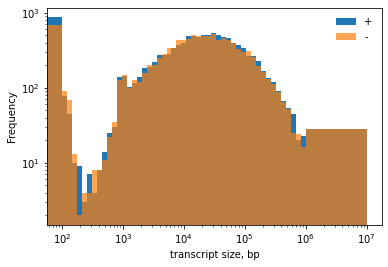

In [9]:
bins = np.r_[0,np.geomspace(100,1_000_000),10_000_000]
gdf[gdf["strand"]=="+"]["size"].plot.hist(bins=bins,log=True,label="+")
gdf[gdf["strand"]=="-"]["size"].plot.hist(bins=bins,log=True,alpha=0.7,label="-")
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("transcript size, bp")
ax.legend(frameon=False)

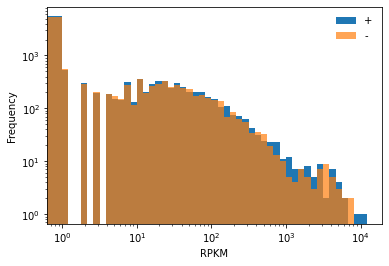

In [10]:
# actually - negative polarity genes are less expressed than tha positive strand genes ...
bins = np.r_[0,np.geomspace(1,12000)]
gdf[gdf["strand"]=="+"]["exp"].plot.hist(bins=bins,log=True,label="+")
gdf[gdf["strand"]=="-"]["exp"].plot.hist(bins=bins,log=True,alpha=0.7,label="-")
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("RPKM")
ax.legend(frameon=False)

In [11]:
exp_bin_edges = [0,1,10,np.inf]
exp_labels = ("no","low","high")
sizes_bin_edges = [0,50_000,np.inf]
sizes_labels = ("short","long")

gdf["gexp"] = pd.cut(
    gdf["exp"],
    bins = exp_bin_edges,
    labels = exp_labels,
    include_lowest = True
)
gdf["gsize"] = pd.cut(
    gdf["size"],
    bins = sizes_bin_edges,
    labels = sizes_labels,
    include_lowest = True
)
display(gdf.head())
display( gdf.groupby(["gexp","gsize"]).size().unstack(fill_value=0) )

,chrom,start,end,strand,exp,size,gexp,gsize
0,chr1,11873,14409,+,0,2536,no,short
1,chr1,14361,29370,-,32,15009,high,short
2,chr1,69090,70008,+,0,918,no,short
3,chr1,134772,140566,-,0,5794,no,short
4,chr1,562759,564389,-,0,1630,no,short


gsize,short,long
gexp,,
no,9492,2418
low,1842,1227
high,5035,2280


In [12]:
# extend the stacking region by the gene length on each side !
gdf["start"] = gdf["start"] - gdf["size"]
gdf["end"] = gdf["end"] + gdf["size"]

In [13]:
def extract_ins(df,
                fname,
                bins=3000,
                flip_by_strand=False,
               ):
    """
    for a BED-like DF, extract 'signal' from BW (fname) for every interval
    use "strand" information to flip "-" strand genes (or not) ...
    """
    if flip_by_strand:
        return np.asarray([
            bbi.fetch
                   (
                        fname,
                        chrom,
                        start,
                        end,
                        bins=bins,
                        missing=0.0,
                        oob=np.nan,
                        summary='mean',
                    )[:: (1 if strand=="+" else -1) ] # flip in place for "-" genes
          for chrom, start, end, strand, *_ in df.sort_values(by="exp").itertuples(index=False)
        ])
    else:
        return np.asarray([
            bbi.fetch
                   (
                        fname,
                        chrom,
                        start,
                        end,
                        bins=bins,
                        missing=0.0,
                        oob=np.nan,
                        summary='mean',
                    )
          for chrom, start, end, *_ in df.sort_values(by="exp").itertuples(index=False)
        ])


### TSS to TTS scaled profiles ...

In [14]:
# key features/signals that we want to extract for our genes ...
key_features = [ 'ins_mutCtr_CTCF',
                 'ins_mutCtr_noCTCF',
                "ins_mutDDX_CTCF",
                "ins_mutDDX_noCTCF",
                "ctcf",
                "Rloop_K562",
                'rad21_CTCF',
                'rad21_noCTCF',
               ]
#                 "ins_PlaB_CTCF",
#                 "ins_PlaB_noCTCF",
#                "ev1_CtrPlaB_CTCF",
#                 "ev1_CtrPlaB_noCTCF",
#                 "ev1_PlaB_CTCF",
#                 "ev1_PlaB_noCTCF"]

### Extracting Meta-gene profiles of the key-features (insulations, Chip_Seq data etc)

#### Here we extract data for + and - genes separately and flip "-" genes to orient them same way as the "+" genes ...
#### using `extract_ins` function...

In [15]:
profiles_dict = {}

# group genes by expression and size before extracting corresponding profiles of a list of features :
gene_groups = gdf.groupby(["gexp","gsize"])
for feature_name in key_features:
    print(f"extracting {feature_name} for the genes ...")
    feature_fname = samples[feature_name]["fname"]
    profiles_dict[feature_name] = gene_groups.apply(
                                    lambda sub_df: extract_ins(
                                        sub_df,
                                        feature_fname,
                                        bins=3000,
                                        flip_by_strand=True,
                                    )
                                )

extracting ins_mutCtr_CTCF for the genes ...
extracting ins_mutCtr_noCTCF for the genes ...
extracting ins_mutDDX_CTCF for the genes ...
extracting ins_mutDDX_noCTCF for the genes ...
extracting ctcf for the genes ...
extracting Rloop_K562 for the genes ...
extracting rad21_CTCF for the genes ...
extracting rad21_noCTCF for the genes ...


In [16]:
profiles_dict.keys()

dict_keys(['ins_mutCtr_CTCF', 'ins_mutCtr_noCTCF', 'ins_mutDDX_CTCF', 'ins_mutDDX_noCTCF', 'ctcf', 'Rloop_K562', 'rad21_CTCF', 'rad21_noCTCF'])

In [17]:
insulation_keys = [k for k in key_features if k.startswith("ins")]
for ins_feature in insulation_keys:
#     profiles_dict[ins_feature] = profiles_dict[ins_feature].to_dict()
    for key, ins_stack in profiles_dict[ins_feature].items():
        l,w = ins_stack.shape
        flank_size = int(w*0.25)
        # get shoulders of the stack
        shoulder_idxs = np.r_[:flank_size,w-flank_size:w]
        profiles_dict[ins_feature][key] = ins_stack - \
            np.nanmean(
                ins_stack[:,shoulder_idxs],
                axis=1,
                keepdims=True
            )


In [18]:
# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
reordered_jdxs = OrderedDict()
for feature_key in [("high","long"), ("no","long")]:
#     stackup_for_sorting = profiles_dict["ctcf"][feature_key]
    stackup_for_sorting = profiles_dict["ins_mutDDX_CTCF"][feature_key]
    # for a given set of stackups for a given list of features ...
    length,width = stackup_for_sorting.shape
    TSS_bin = int(width/3)
    TTS_bin = int(2*width/3)

    tmp_stack = {}
#     tmp_stack['ctcf_mean'] = np.nanmean(stackup_for_sorting[:,TSS_bin-2:TSS_bin+2],axis=1)
    tmp_stack['ins_mean'] = np.nanmean(stackup_for_sorting[:,TSS_bin:TTS_bin],axis=1)
    
    _, _jjj = recursive_data_ordering(
        ks = [('ins_mean', "sort", 1, False)],
        idxs = np.arange( length ),
        data_dict = tmp_stack,
        verbose=True
    )
    reordered_jdxs[feature_key] = _jjj

sorting 2280 elements of ins_mean into 1 groups ...
sorting 2418 elements of ins_mean into 1 groups ...


In [19]:
titles = key_features

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in key_features:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = samples[s]["norm"]
    
    
# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.15,.1)
    cmps[s] = cmapYlGnBu_r

limss["ctcf"] = (0,0.85)
limss["Rloop_K562"] = (0,5)
limss['rad21_CTCF'] = (0,.3)
limss['rad21_noCTCF'] = (0,.3)



hmss = OrderedDict()

for feature_key in [("high","long"), ("no","long")]:
#     jjj = reordered_jdxs[feature_key]
    hmss[feature_key] = [ profiles_dict[_k][feature_key] for _k in key_features ]

_limss = [ limss[_k] for _k in key_features ]
_cmps = [ cmps[_k] for _k in key_features ]
_binsizes = [ binsizes[_k] for _k in key_features ]
_norms = [ norms[_k] for _k in key_features ]


#### Plotting the profiles ...

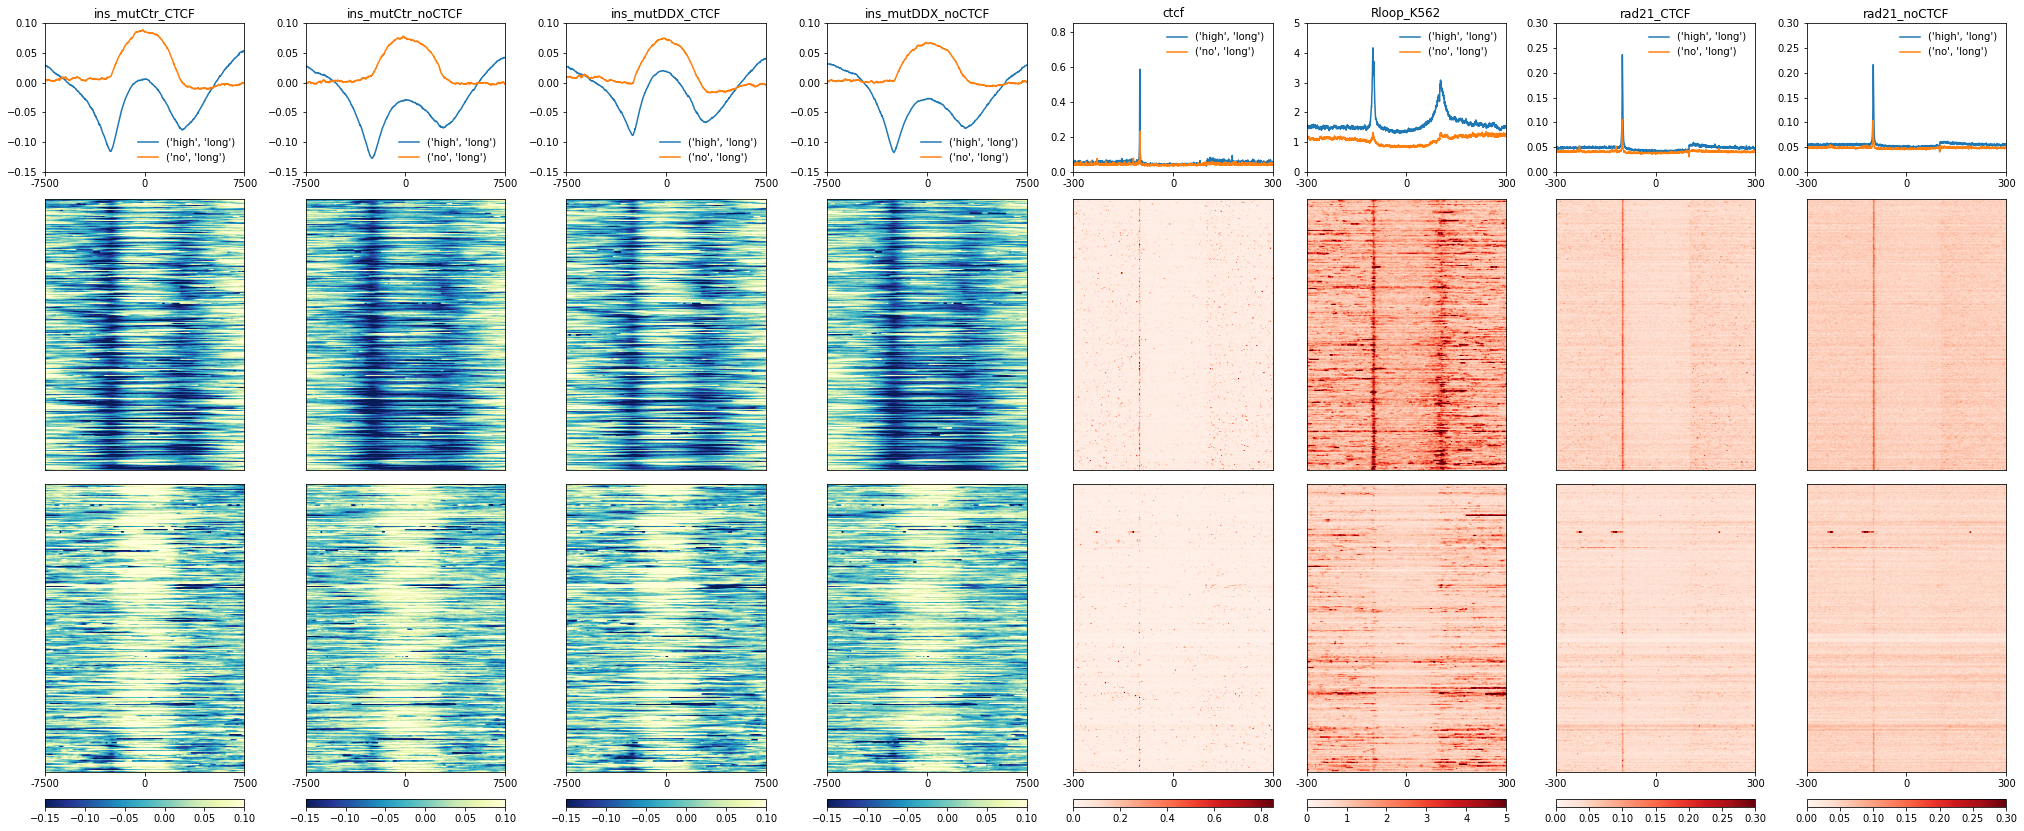

In [22]:
# ordered by the gene size ...
plot_sss( hmss = hmss,
          titles = titles,
          limss = _limss,
          cmps = _cmps,
          norms=_norms,
          binsizes=_binsizes,
          labels=None,
          fillmissing=True,
          interpolation="bilinear",
          inch_per_1k_stack = 1.9,
         )

In [21]:
def plot_sss(
          hmss, # will become a dictionary now (or list) ...
          titles,
          limss,
          cmps,
          norms=None,
          binsizes=None,
          labels=None,
          fillmissing=False,
          interpolation="nearest",
          inch_per_1k_stack= 1.2, #inches per 1000 elements stackup ...
         ):
    # rewrite everyhting assuming hmss is a dict of stackup groups !
    # groups are plotted on top of each other ...
    
    # regardless - claculate number of axes for stackups ...
    num_stackup_groups = len(hmss)
    # pick in every stackup group and see how many are there
    num_stackups = max(len(hmss[k]) for k in hmss)
    num_rows = num_stackups
    # let's figure out - how tall is this stackup
    # get heights of stackups from each groups
    stackup_group_heights = [len(hmss[k][0]) for k in hmss]
    stackup_height = sum(stackup_group_heights)*inch_per_1k_stack/1_000
    figure_height = stackup_height + 2.5
    fig = plt.figure(
        figsize=(3.5*num_rows, figure_height),
        facecolor="white",
        constrained_layout=True
    )
    gs = fig.add_gridspec(
        num_stackup_groups+2,
        num_rows,
        width_ratios=[1]*num_rows,
        height_ratios = \
            [0.95*2.5/figure_height] + \
            [(_h/sum(stackup_group_heights))*(figure_height-2.5)/figure_height for _h in stackup_group_heights] + \
            [0.05*2.5/figure_height]
    )

    ax_profile = {}
    ax_stackup = {}
    ax_cbar = {}
    hmss_order = list( range(num_rows) )
    # replace following with the pre-defined column indexes ...
    for idx in hmss_order:
        ax_profile[idx] = fig.add_subplot(gs[0,idx])
        ax_stackup[idx] = [fig.add_subplot(gs[_i+1,idx]) for _i in range(num_stackup_groups)] # stackup groups ...
        ax_cbar[idx] = fig.add_subplot(gs[-1,idx])

    hm_arr = {}
    profile_hm = {}
    labels_dict = {}
    # for each group of stackups (vertically set)
    for group_id, k in enumerate(hmss):
        hm_arr[group_id] = {}
        profile_hm[group_id] = {}
        labels_dict[group_id] = {}
        # for every stackup in each group (horizontal set)
        for idx, hm in zip(hmss_order, hmss[k]):
            if fillmissing:
                X = hm[:]
                missing = ~np.isfinite(X)
                mu = np.nanmean(X, axis=0, keepdims=True) # axis 0 or 1 - rows or columns ?!
                hm_arr[group_id][idx] = np.where(missing, mu, X)
            else:
                hm_arr[group_id][idx] = hm[:]
            profile_hm[group_id][idx] = np.nanmean(hm_arr[group_id][idx],axis=0)
            labels_dict[group_id][idx] = k
    
    # turning some of the input parameters into "oredered" or labeled dicts ...
    if norms is None:
        norms = { _i:None for _i in hmss_order}
    else:
        norms = { _i:norms[i] for i,_i in enumerate(hmss_order)}
    vlims = { _i:limss[i] for i,_i in enumerate(hmss_order)}
    titles = { _i:titles[i] for i,_i in enumerate(hmss_order)}
    if binsizes is None:
        binsizes = { _i:1 for _i in hmss_order}
    else:
        binsizes = { _i:binsizes[i] for i,_i in enumerate(hmss_order)}

    for idx, cmap in zip(hmss_order, cmps):
        # plot profiles from every group on a single common axis for profiles...
        for _i in range(num_stackup_groups):
            ax_profile[idx].plot(profile_hm[_i][idx], label=labels_dict[_i][idx])
        ax_profile[idx].set_yscale("linear" if norms[idx] is None else "log")
        ax_profile[idx].legend(frameon=False)
        # stackups for every group ...
        for _i in range(num_stackup_groups):
            stack_hm = ax_stackup[idx][_i].imshow(
                              hm_arr[_i][idx],
                              norm=norms[idx],
                              aspect="auto",
                              vmin=vlims[idx][0],
                              vmax=vlims[idx][1],
                              cmap=cmap,
                              interpolation=interpolation,
            )
        # beautify ...
        group_id_beautify = 0
        first_bin = 0-.5
        center_bin = hm_arr[group_id_beautify][idx].shape[1]/2 - .5
        last_bin = hm_arr[group_id_beautify][idx].shape[1]-.5
        ax_profile[idx].set_xlim([first_bin, last_bin])
        ax_profile[idx].set_ylim(vlims[idx])
        ax_profile[idx].set_title(titles[idx])
        # human readable kb stuff:
        flank_in_kb = int((center_bin+.5)*binsizes[idx]/1000)
        flank_ticks = [first_bin, center_bin, last_bin]
        flank_ticklabels = [-flank_in_kb, 0, flank_in_kb]
        ax_profile[idx].set_xticks(flank_ticks)
        ax_profile[idx].set_xticklabels(flank_ticklabels)
        for _i in range(num_stackup_groups-1):
            ax_stackup[idx][_i].set_xticks([])
            ax_stackup[idx][_i].set_xticklabels([])
            ax_stackup[idx][_i].set_yticks([])
            ax_stackup[idx][_i].set_yticklabels([])
        # bottom one - show ticks for now ...
        _i = num_stackup_groups-1
        ax_stackup[idx][_i].set_xticks(flank_ticks)
        ax_stackup[idx][_i].set_xticklabels(flank_ticklabels)
        ax_stackup[idx][_i].set_yticks([])
        ax_stackup[idx][_i].set_yticklabels([])
        plt.colorbar(stack_hm,cax=ax_cbar[idx],orientation="horizontal")
        
    return None


#### Plotting the profiles ...

In [ ]:
# ordered by the gene size ...
plot_sss( hmss = {"1":[pgene_profiles[("no","medium")]],
                  "2":[pgene_profiles[("low","medium")]],
                  "3":[pgene_profiles[("med","medium")]],
                  "4":[pgene_profiles[("high","medium")]],
                 },
          titles = ["yyy"],
          limss = [(.5,6)],
          cmps = ["YlGnBu_r"],
          norms=None,
          binsizes=None,
          labels=None,
          fillmissing=True,
          interpolation="bilinear",
          inch_per_1k_stack = 1.9,
         )

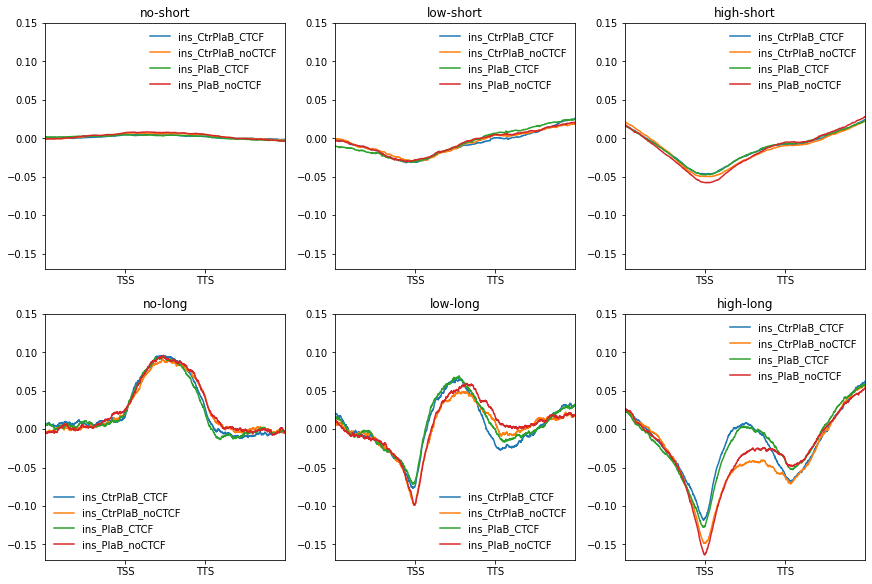

In [31]:
glens=("short","long")
gexps=("no","low","high")

mutant_keys = [k for k in key_features if k.startswith("ins") ]

fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(len(glens),len(gexps))

for i,glen in enumerate(glens):
    for j,gexp in enumerate(gexps):
        ax = fig.add_subplot(gs[i,j])
        for feature_name in mutant_keys:
            ins_profiles = profiles_dict[feature_name]
            ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
        ax.set_title(f"{gexp}-{glen}")
        ax.legend(frameon=False)
        ax.set_ylim(-0.17,.15)
        ax.set_xlim(0,3000)
        ax.set_xticks([1000,2000])
        ax.set_xticklabels(["TSS","TTS"])

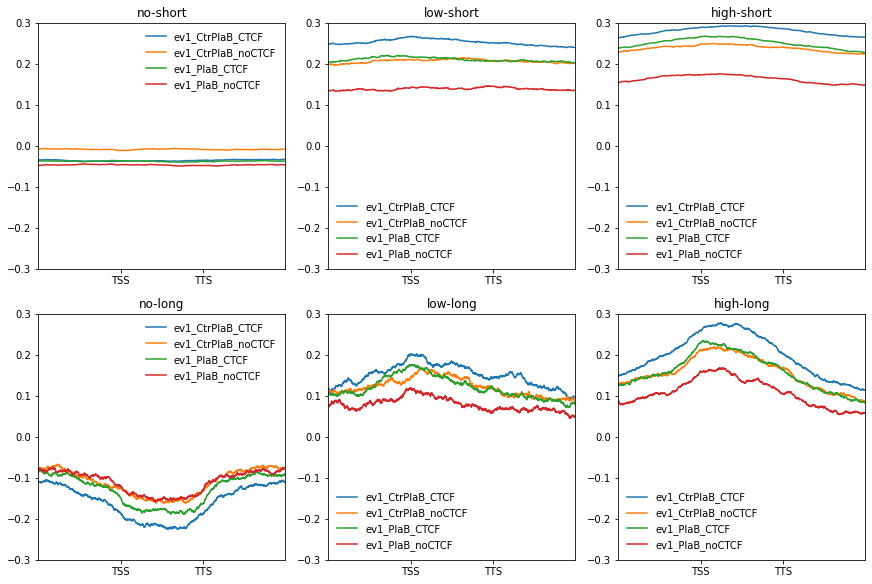

In [29]:
glens=("short","long")
gexps=("no","low","high")

mutant_keys = [k for k in key_features if k.startswith("ev1") ]

fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(len(glens),len(gexps))

for i,glen in enumerate(glens):
    for j,gexp in enumerate(gexps):
        ax = fig.add_subplot(gs[i,j])
        for feature_name in mutant_keys:
            ins_profiles = profiles_dict[feature_name]
            ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
        ax.set_title(f"{gexp}-{glen}")
        ax.legend(frameon=False)
        ax.set_ylim(-0.3,.3)
        ax.set_xlim(0,3000)
        ax.set_xticks([1000,2000])
        ax.set_xticklabels(["TSS","TTS"])

### Figure 3C itself ! comparing average insulation


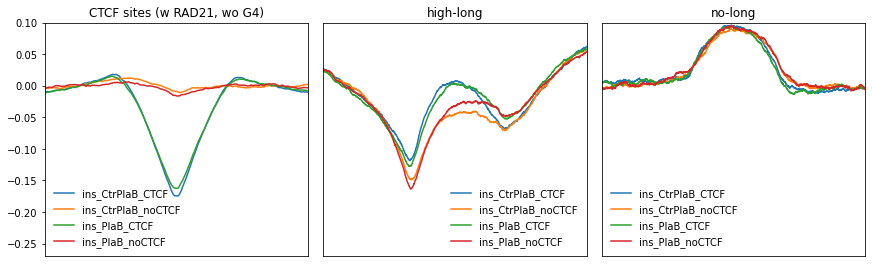

In [23]:
fig = plt.figure(figsize=(12,7),constrained_layout=True)
gs = fig.add_gridspec(2,3)
ins_ylim = (-0.27,.1)
rloop_ylim = (.7,4.5)

ins_keys_figure = key_features
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[0,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([])
ax.set_xticklabels([])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[0,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])




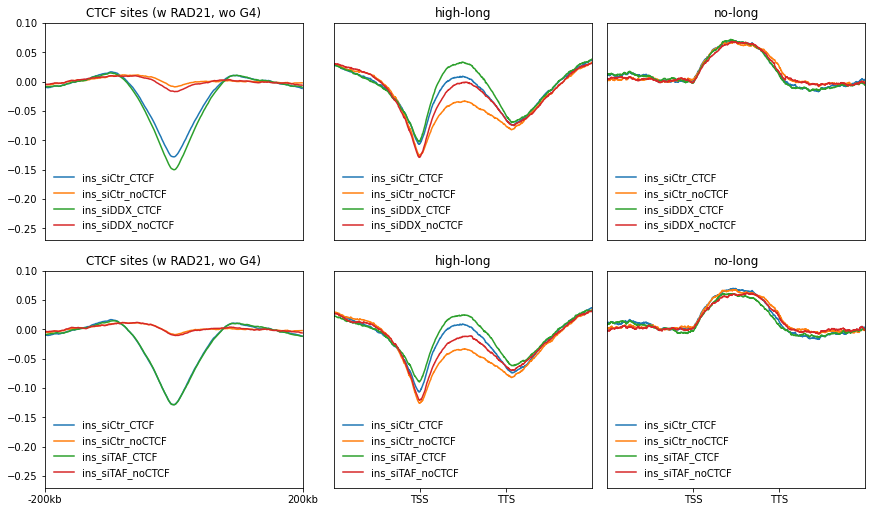

In [34]:
fig = plt.figure(figsize=(12,7),constrained_layout=True)
gs = fig.add_gridspec(2,3)
ins_ylim = (-0.27,.1)
rloop_ylim = (.7,4.5)

ins_keys_figure = [k for k in key_features if (k.startswith("ins_siCtr") or k.startswith("ins_siDDX")) ]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[0,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([])
ax.set_xticklabels([])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[0,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])


ins_keys_figure = [k for k in key_features if (k.startswith("ins_siCtr") or k.startswith("ins_siTAF")) ]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[1,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([0,300])
ax.set_xticklabels(["-200kb","200kb"])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[1,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([1000,2000])
    ax.set_xticklabels(["TSS","TTS"])
    ax.set_yticks([])
    ax.set_yticklabels([])

plt.savefig("Figure6-siRNA-metaGene-insulation.pdf")    

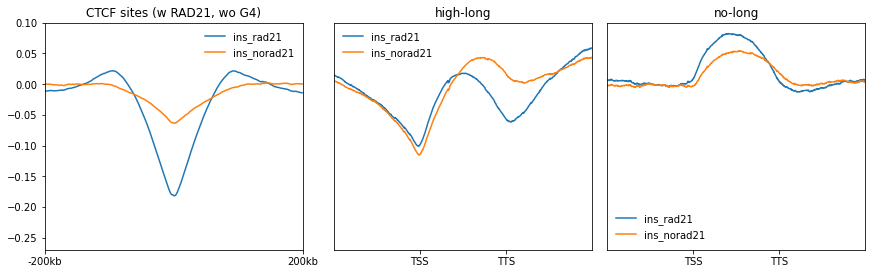

In [31]:
fig = plt.figure(figsize=(12,7),constrained_layout=True)
gs = fig.add_gridspec(2,3)
ins_ylim = (-0.27,.1)
rloop_ylim = (.7,4.5)

ins_keys_figure = ["ins_rad21","ins_norad21"]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[1,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([0,300])
ax.set_xticklabels(["-200kb","200kb"])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[1,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([1000,2000])
    ax.set_xticklabels(["TSS","TTS"])
    ax.set_yticks([])
    ax.set_yticklabels([])

plt.savefig("SuppFig3H-RAD21degron-metaGene-insulation-profile.pdf")